In [1]:
import json
import pandas as pd
from dataclasses import dataclass
from typing import List
import matplotlib.pyplot as plt

@dataclass
class Trade:
    timestamp: int
    buyer: str
    seller: str
    symbol: str
    currency: str
    price: float
    quantity: int

# Read entire log file
with open('/Users/vasudev/Desktop/Projects/imc_prosperity/prosperity-imc25/rounds/round4/eda/logs/6409374e-bd65-4670-bb45-c6dd8d8e34f5.log', 'r') as f:
    content = f.read()

# --- Parse Sandbox Logs ---
sandbox_start = content.find('Sandbox logs:')
activities_start = content.find('Activities log:')
sandbox_section = content[sandbox_start + len('Sandbox logs:'):activities_start].strip()

# Each JSON object is on a new line; wrap in array brackets
# sandbox_json = '[' + ','.join(sandbox_section.split('\n')) + ']'

# sandbox_logs = json.loads(sandbox_json)

# --- Parse Activities Log ---
trades_start = content.find('Trade History:')
activities_section = content[activities_start + len('Activities log:'):trades_start].strip()

# Read CSV section into a DataFrame
from io import StringIO
activities_df = pd.read_csv(StringIO(activities_section), sep=';')

# --- Parse Trades ---
trades_section = content[trades_start + len('Trade History:'):].strip()
trades_data = json.loads(trades_section)

# Convert to Trade objects
trades: List[Trade] = [Trade(**t) for t in trades_data]

In [2]:
our_trades = [trade for trade in trades if trade.buyer == "SUBMISSION" or trade.seller == "SUBMISSION"]
# Convert to DataFrame
trades_df = pd.DataFrame([trade.__dict__ for trade in our_trades])
print(trades_df[trades_df['symbol'].str.contains('VOLCANIC_ROCK_VOUCHER')])
trades_df.to_csv('trades.csv', index=False)
print(len(trades_df))


      timestamp       buyer      seller                       symbol  \
1             0              SUBMISSION  VOLCANIC_ROCK_VOUCHER_10250   
2             0  SUBMISSION              VOLCANIC_ROCK_VOUCHER_10500   
7           100  SUBMISSION              VOLCANIC_ROCK_VOUCHER_10000   
8           100  SUBMISSION              VOLCANIC_ROCK_VOUCHER_10250   
9           100              SUBMISSION  VOLCANIC_ROCK_VOUCHER_10500   
...         ...         ...         ...                          ...   
1858      99400  SUBMISSION              VOLCANIC_ROCK_VOUCHER_10500   
1860      99500              SUBMISSION  VOLCANIC_ROCK_VOUCHER_10250   
1861      99500  SUBMISSION              VOLCANIC_ROCK_VOUCHER_10500   
1863      99900  SUBMISSION              VOLCANIC_ROCK_VOUCHER_10250   
1864      99900              SUBMISSION  VOLCANIC_ROCK_VOUCHER_10500   

       currency  price  quantity  
1     SEASHELLS     36         5  
2     SEASHELLS      4         5  
7     SEASHELLS    181        

In [3]:
from collections import defaultdict
import pandas as pd

# Sort the trades chronologically
our_trades_sorted = sorted(our_trades, key=lambda x: x.timestamp)

# Extract all unique timestamps and products from the activities dataframe
timestamps = sorted(activities_df['timestamp'].unique())
symbols = activities_df['product'].unique()

# Keep track of running position
running_pos = defaultdict(int)
records = []

# Pointer for iterating through our_trades_sorted
t_idx = 0

for t in timestamps:
    # Apply all trades that occurred at this timestamp
    while t_idx < len(our_trades_sorted) and our_trades_sorted[t_idx].timestamp == t:
        trade = our_trades_sorted[t_idx]
        if trade.buyer == "SUBMISSION":
            running_pos[trade.symbol] += trade.quantity
        elif trade.seller == "SUBMISSION":
            running_pos[trade.symbol] -= trade.quantity
        t_idx += 1

    # Record the position for all products at this timestamp
    for symbol in symbols:
        records.append({'timestamp': t, 'product': symbol, 'position': running_pos[symbol]})

# Create DataFrame of positions and merge
position_df = pd.DataFrame(records)
activities_df = activities_df.merge(position_df, on=['timestamp', 'product'], how='left')

In [4]:
activities_df

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss,position
0,3,0,SQUID_INK,1820.0,1.0,1819.0,28.0,NaN,NaN,1822,28,NaN,NaN,NaN,NaN,1821.0,0.000000,0
1,3,0,VOLCANIC_ROCK_VOUCHER_10000,182.0,17.0,NaN,NaN,NaN,NaN,183,17,NaN,NaN,NaN,NaN,182.5,0.000000,0
2,3,0,KELP,2040.0,29.0,NaN,NaN,NaN,NaN,2043,28,NaN,NaN,NaN,NaN,2041.5,0.000000,0
3,3,0,RAINFOREST_RESIN,9992.0,26.0,NaN,NaN,NaN,NaN,10008,26,NaN,NaN,NaN,NaN,10000.0,0.000000,0
4,3,0,VOLCANIC_ROCK_VOUCHER_10250,36.0,17.0,NaN,NaN,NaN,NaN,37,17,NaN,NaN,NaN,NaN,36.5,0.000000,-5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,3,99900,PICNIC_BASKET2,30056.0,1.0,30055.0,39.0,NaN,NaN,30061,1,30062.0,39.0,NaN,NaN,30058.5,0.000000,0
14996,3,99900,VOLCANIC_ROCK_VOUCHER_10500,3.0,13.0,NaN,NaN,NaN,NaN,4,13,NaN,NaN,NaN,NaN,3.5,-841.235474,195
14997,3,99900,RAINFOREST_RESIN,9992.0,27.0,NaN,NaN,NaN,NaN,10008,27,NaN,NaN,NaN,NaN,10000.0,0.000000,0
14998,3,99900,VOLCANIC_ROCK_VOUCHER_10000,189.0,13.0,NaN,NaN,NaN,NaN,190,13,NaN,NaN,NaN,NaN,189.5,2923.359375,200


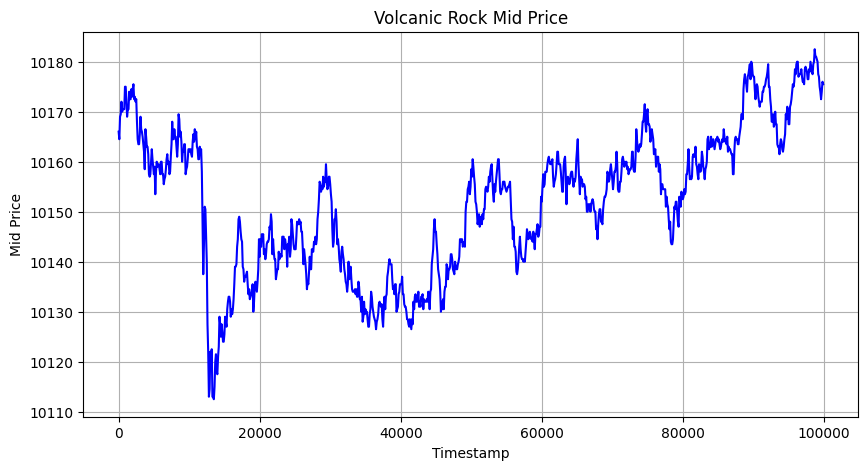

In [5]:
# plot volcanic rock midprice
plt.figure(figsize=(10, 5))
plt.plot(activities_df[activities_df["product"] == "VOLCANIC_ROCK"]['timestamp'], activities_df[activities_df["product"] == "VOLCANIC_ROCK"]['mid_price'], label='Mid Price', color='blue')
plt.title('Volcanic Rock Mid Price')
plt.xlabel('Timestamp')
plt.ylabel('Mid Price')
plt.grid()



In [6]:
#last mid price
print(activities_df[activities_df['product'] == 'RAINFOREST_RESIN']['mid_price'].iloc[-1])

10000.0


In [7]:
symbols = ["RAINFOREST_RESIN", "KELP", "SQUID_INK", "CROISSANTS", "JAMS", "DJEMBES", "PICNIC_BASKET1", "PICNIC_BASKET2"]

rfr_trades = [trade for trade in trades if trade.symbol == 'RAINFOREST_RESIN']
kelp_trades = [trade for trade in trades if trade.symbol == 'KELP']
squid_ink_trades = [trade for trade in trades if trade.symbol == 'SQUID_INK']
croissants_trades = [trade for trade in trades if trade.symbol == 'CROISSANTS']
jams_trades = [trade for trade in trades if trade.symbol == 'JAMS']
djembes_trades = [trade for trade in trades if trade.symbol == 'DJEMBES']
pic1_trades = [trade for trade in trades if trade.symbol == 'PICNIC_BASKET1']
pic2_trades = [trade for trade in trades if trade.symbol == 'PICNIC_BASKET2']
volcanic_trades = [trade for trade in trades if trade.symbol == 'VOLCANIC_ROCK']
volcanic_rock_voucher_9500_trades = [trade for trade in trades if trade.symbol == 'VOLCANIC_ROCK_VOUCHER_9500']
volcanic_rock_voucher_9750_trades = [trade for trade in trades if trade.symbol == 'VOLCANIC_ROCK_VOUCHER_9750']
volcanic_rock_voucher_10000_trades = [trade for trade in trades if trade.symbol == 'VOLCANIC_ROCK_VOUCHER_10000']
volcanic_rock_voucher_10250_trades = [trade for trade in trades if trade.symbol == 'VOLCANIC_ROCK_VOUCHER_10250']
volcanic_rock_voucher_10500_trades = [trade for trade in trades if trade.symbol == 'VOLCANIC_ROCK_VOUCHER_10500']



# our trades
rfr_buys = [trade for trade in rfr_trades if trade.buyer == 'SUBMISSION']
rfr_sells = [trade for trade in rfr_trades if trade.seller == 'SUBMISSION']
outstanding_rfr_position = sum(trade.quantity for trade in rfr_buys) - sum(trade.quantity for trade in rfr_sells)

kelp_buys = [trade for trade in kelp_trades if trade.buyer == 'SUBMISSION']
kelp_sells = [trade for trade in kelp_trades if trade.seller == 'SUBMISSION']
outstanding_kelp_position = sum(trade.quantity for trade in kelp_buys) - sum(trade.quantity for trade in kelp_sells)

squid_ink_buys = [trade for trade in squid_ink_trades if trade.buyer == 'SUBMISSION']
squid_ink_sells = [trade for trade in squid_ink_trades if trade.seller == 'SUBMISSION']
outstanding_squid_ink_position = sum(trade.quantity for trade in squid_ink_buys) - sum(trade.quantity for trade in squid_ink_sells)

croissants_buys = [trade for trade in croissants_trades if trade.buyer == 'SUBMISSION']
croissants_sells = [trade for trade in croissants_trades if trade.seller == 'SUBMISSION']
outstanding_croissants_position = sum(trade.quantity for trade in croissants_buys) - sum(trade.quantity for trade in croissants_sells)

jams_buys = [trade for trade in jams_trades if trade.buyer == 'SUBMISSION']
jams_sells = [trade for trade in jams_trades if trade.seller == 'SUBMISSION']
outstanding_jams_position = sum(trade.quantity for trade in jams_buys) - sum(trade.quantity for trade in jams_sells)

djembes_buys = [trade for trade in djembes_trades if trade.buyer == 'SUBMISSION']
djembes_sells = [trade for trade in djembes_trades if trade.seller == 'SUBMISSION']
outstanding_djembes_position = sum(trade.quantity for trade in djembes_buys) - sum(trade.quantity for trade in djembes_sells)

pic1_buys = [trade for trade in pic1_trades if trade.buyer == 'SUBMISSION']
pic1_sells = [trade for trade in pic1_trades if trade.seller == 'SUBMISSION']
outstanding_pic1_position = sum(trade.quantity for trade in pic1_buys) - sum(trade.quantity for trade in pic1_sells)

pic2_buys = [trade for trade in pic2_trades if trade.buyer == 'SUBMISSION']
pic2_sells = [trade for trade in pic2_trades if trade.seller == 'SUBMISSION']
outstanding_pic2_position = sum(trade.quantity for trade in pic2_buys) - sum(trade.quantity for trade in pic2_sells)

volcanic_buys = [trade for trade in volcanic_trades if trade.buyer == 'SUBMISSION']
volcanic_sells = [trade for trade in volcanic_trades if trade.seller == 'SUBMISSION']
outstanding_volcanic_position = sum(trade.quantity for trade in volcanic_buys) - sum(trade.quantity for trade in volcanic_sells)

volcanic_rock_voucher_9500_buys = [trade for trade in volcanic_rock_voucher_9500_trades if trade.buyer == 'SUBMISSION']
volcanic_rock_voucher_9500_sells = [trade for trade in volcanic_rock_voucher_9500_trades if trade.seller == 'SUBMISSION']
outstanding_volcanic_rock_voucher_9500_position = sum(trade.quantity for trade in volcanic_rock_voucher_9500_buys) - sum(trade.quantity for trade in volcanic_rock_voucher_9500_sells)

volcanic_rock_voucher_9750_buys = [trade for trade in volcanic_rock_voucher_9750_trades if trade.buyer == 'SUBMISSION']
volcanic_rock_voucher_9750_sells = [trade for trade in volcanic_rock_voucher_9750_trades if trade.seller == 'SUBMISSION']
outstanding_volcanic_rock_voucher_9750_position = sum(trade.quantity for trade in volcanic_rock_voucher_9750_buys) - sum(trade.quantity for trade in volcanic_rock_voucher_9750_sells)

volcanic_rock_voucher_10000_buys = [trade for trade in volcanic_rock_voucher_10000_trades if trade.buyer == 'SUBMISSION']
volcanic_rock_voucher_10000_sells = [trade for trade in volcanic_rock_voucher_10000_trades if trade.seller == 'SUBMISSION']
outstanding_volcanic_rock_voucher_10000_position = sum(trade.quantity for trade in volcanic_rock_voucher_10000_buys) - sum(trade.quantity for trade in volcanic_rock_voucher_10000_sells)

volcanic_rock_voucher_10250_buys = [trade for trade in volcanic_rock_voucher_10250_trades if trade.buyer == 'SUBMISSION']
volcanic_rock_voucher_10250_sells = [trade for trade in volcanic_rock_voucher_10250_trades if trade.seller == 'SUBMISSION']
outstanding_volcanic_rock_voucher_10250_position = sum(trade.quantity for trade in volcanic_rock_voucher_10250_buys) - sum(trade.quantity for trade in volcanic_rock_voucher_10250_sells)

volcanic_rock_voucher_10500_buys = [trade for trade in volcanic_rock_voucher_10500_trades if trade.buyer == 'SUBMISSION']
volcanic_rock_voucher_10500_sells = [trade for trade in volcanic_rock_voucher_10500_trades if trade.seller == 'SUBMISSION']
outstanding_volcanic_rock_voucher_10500_position = sum(trade.quantity for trade in volcanic_rock_voucher_10500_buys) - sum(trade.quantity for trade in volcanic_rock_voucher_10500_sells)



In [8]:
print(f"Outstanding RAINFOREST_RESIN position: {outstanding_rfr_position}")
print(f"Outstanding KELP position: {outstanding_kelp_position}")
print(f"Outstanding SQUID_INK position: {outstanding_squid_ink_position}")
print(f"Outstanding CROISSANTS position: {outstanding_croissants_position}")
print(f"Outstanding JAMS position: {outstanding_jams_position}")
print(f"Outstanding DJEMBES position: {outstanding_djembes_position}")
print(f"Outstanding PICNIC_BASKET1 position: {outstanding_pic1_position}")
print(f"Outstanding PICNIC_BASKET2 position: {outstanding_pic2_position}")
print(f"Outstanding VOLCANIC_ROCK position: {outstanding_volcanic_position}")
print(f"Outstanding VOLCANIC_ROCK_VOUCHER_9500 position: {outstanding_volcanic_rock_voucher_9500_position}")
print(f"Outstanding VOLCANIC_ROCK_VOUCHER_9750 position: {outstanding_volcanic_rock_voucher_9750_position}")
print(f"Outstanding VOLCANIC_ROCK_VOUCHER_10000 position: {outstanding_volcanic_rock_voucher_10000_position}")
print(f"Outstanding VOLCANIC_ROCK_VOUCHER_10250 position: {outstanding_volcanic_rock_voucher_10250_position}")
print(f"Outstanding VOLCANIC_ROCK_VOUCHER_10500 position: {outstanding_volcanic_rock_voucher_10500_position}")


Outstanding RAINFOREST_RESIN position: 0
Outstanding KELP position: 0
Outstanding SQUID_INK position: 0
Outstanding CROISSANTS position: 0
Outstanding JAMS position: 0
Outstanding DJEMBES position: 0
Outstanding PICNIC_BASKET1 position: 0
Outstanding PICNIC_BASKET2 position: 0
Outstanding VOLCANIC_ROCK position: 398
Outstanding VOLCANIC_ROCK_VOUCHER_9500 position: 200
Outstanding VOLCANIC_ROCK_VOUCHER_9750 position: -109
Outstanding VOLCANIC_ROCK_VOUCHER_10000 position: 200
Outstanding VOLCANIC_ROCK_VOUCHER_10250 position: 195
Outstanding VOLCANIC_ROCK_VOUCHER_10500 position: 195


In [9]:
total_outstanding_position_value = (
    outstanding_rfr_position * activities_df[activities_df['product'] == 'RAINFOREST_RESIN']['mid_price'].iloc[-1] +
    outstanding_kelp_position * activities_df[activities_df['product'] == 'KELP']['mid_price'].iloc[-1] +
    outstanding_squid_ink_position * activities_df[activities_df['product'] == 'SQUID_INK']['mid_price'].iloc[-1] +
    outstanding_croissants_position * activities_df[activities_df['product'] == 'CROISSANTS']['mid_price'].iloc[-1] +
    outstanding_jams_position * activities_df[activities_df['product'] == 'JAMS']['mid_price'].iloc[-1] +
    outstanding_djembes_position * activities_df[activities_df['product'] == 'DJEMBES']['mid_price'].iloc[-1] +
    outstanding_pic1_position * activities_df[activities_df['product'] == 'PICNIC_BASKET1']['mid_price'].iloc[-1] +
    outstanding_pic2_position * activities_df[activities_df['product'] == 'PICNIC_BASKET2']['mid_price'].iloc[-1] +
    outstanding_volcanic_position * activities_df[activities_df['product'] == 'VOLCANIC_ROCK']['mid_price'].iloc[-1] +
    outstanding_volcanic_rock_voucher_9500_position * activities_df[activities_df['product'] == 'VOLCANIC_ROCK_VOUCHER_9500']['mid_price'].iloc[-1] +
    outstanding_volcanic_rock_voucher_9750_position * activities_df[activities_df['product'] == 'VOLCANIC_ROCK_VOUCHER_9750']['mid_price'].iloc[-1] +
    outstanding_volcanic_rock_voucher_10000_position * activities_df[activities_df['product'] == 'VOLCANIC_ROCK_VOUCHER_10000']['mid_price'].iloc[-1] +
    outstanding_volcanic_rock_voucher_10250_position * activities_df[activities_df['product'] == 'VOLCANIC_ROCK_VOUCHER_10250']['mid_price'].iloc[-1] +
    outstanding_volcanic_rock_voucher_10500_position * activities_df[activities_df['product'] == 'VOLCANIC_ROCK_VOUCHER_10500']['mid_price'].iloc[-1]
)

print(f"Total outstanding position value: {total_outstanding_position_value}")

Total outstanding position value: 4184355.5


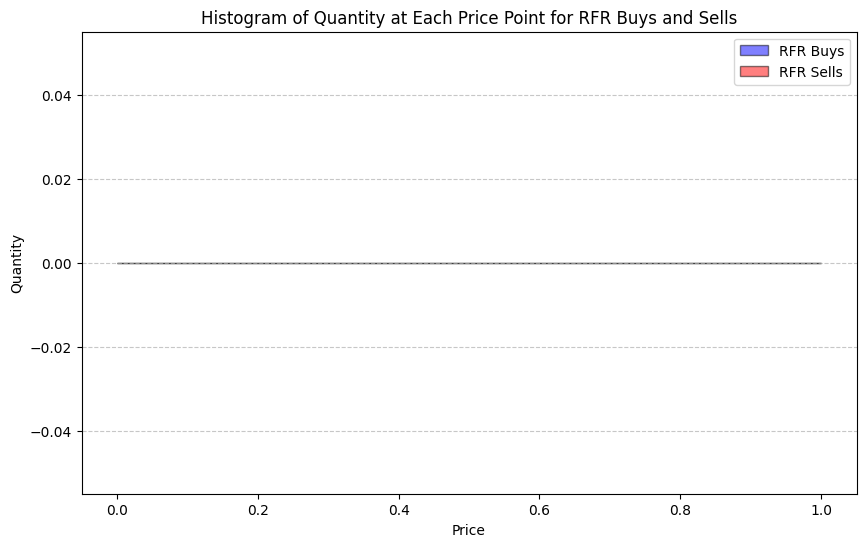

In [10]:
# Extract price and quantity data for rfr_buys and rfr_sells
buy_prices = [trade.price for trade in rfr_buys]
buy_quantities = [trade.quantity for trade in rfr_buys]

sell_prices = [trade.price for trade in rfr_sells]
sell_quantities = [trade.quantity for trade in rfr_sells]

# Create a histogram
plt.figure(figsize=(10, 6))
plt.hist(buy_prices, weights=buy_quantities, bins=20, edgecolor='black', alpha=0.5, label='RFR Buys', color='blue')
plt.hist(sell_prices, weights=sell_quantities, bins=20, edgecolor='black', alpha=0.5, label='RFR Sells', color='red')
plt.title('Histogram of Quantity at Each Price Point for RFR Buys and Sells')
plt.xlabel('Price')
plt.ylabel('Quantity')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [11]:
rfr_bot_trades = [trade for trade in rfr_trades if trade.buyer != 'SUBMISSION' and trade.seller != 'SUBMISSION']
kelp_bot_trades = [trade for trade in kelp_trades if trade.buyer != 'SUBMISSION' and trade.seller != 'SUBMISSION']
squid_ink_bot_trades = [trade for trade in squid_ink_trades if trade.buyer != 'SUBMISSION' and trade.seller != 'SUBMISSION']
croissants_bot_trades = [trade for trade in croissants_trades if trade.buyer != 'SUBMISSION' and trade.seller != 'SUBMISSION']
jams_bot_trades = [trade for trade in jams_trades if trade.buyer != 'SUBMISSION' and trade.seller != 'SUBMISSION']
djembes_bot_trades = [trade for trade in djembes_trades if trade.buyer != 'SUBMISSION' and trade.seller != 'SUBMISSION']
pic1_bot_trades = [trade for trade in pic1_trades if trade.buyer != 'SUBMISSION' and trade.seller != 'SUBMISSION']
pic2_bot_trades = [trade for trade in pic2_trades if trade.buyer != 'SUBMISSION' and trade.seller != 'SUBMISSION']

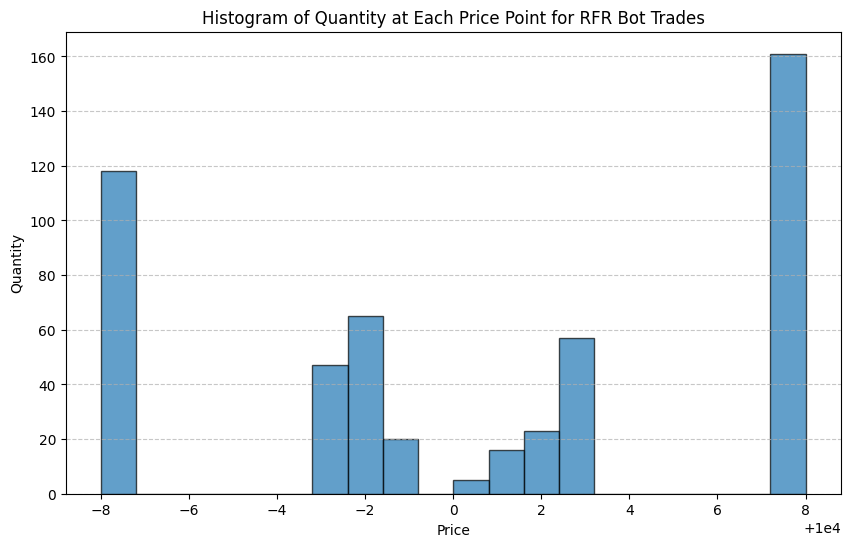

In [350]:
import matplotlib.pyplot as plt

# Extract price and quantity data
prices = [trade.price for trade in rfr_bot_trades]
quantities = [trade.quantity for trade in rfr_bot_trades]

# Create a histogram
plt.figure(figsize=(10, 6))
plt.hist(prices, weights=quantities, bins=20, edgecolor='black', alpha=0.7)
plt.title('Histogram of Quantity at Each Price Point for RFR Bot Trades')
plt.xlabel('Price')
plt.ylabel('Quantity')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

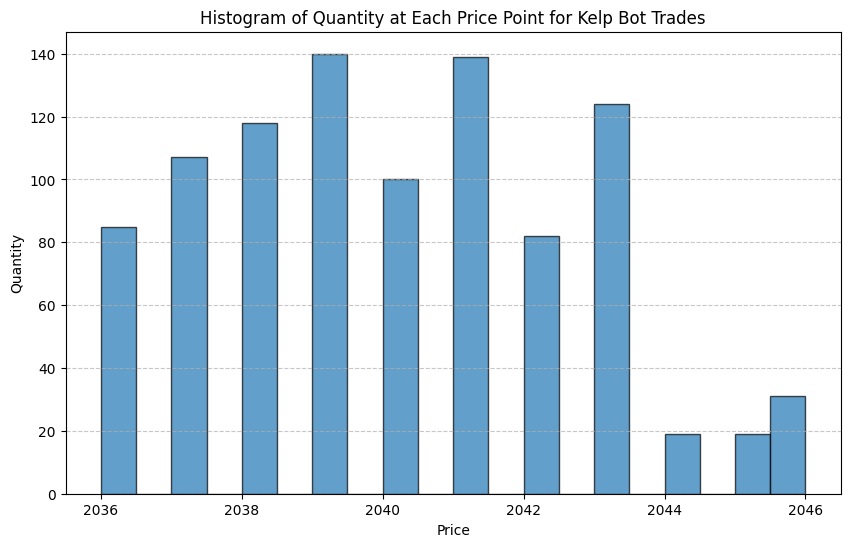

In [351]:

# Extract price and quantity data
prices = [trade.price for trade in kelp_bot_trades]
quantities = [trade.quantity for trade in kelp_bot_trades]

# Create a histogram
plt.figure(figsize=(10, 6))
plt.hist(prices, weights=quantities, bins=20, edgecolor='black', alpha=0.7)
plt.title('Histogram of Quantity at Each Price Point for Kelp Bot Trades')
plt.xlabel('Price')
plt.ylabel('Quantity')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

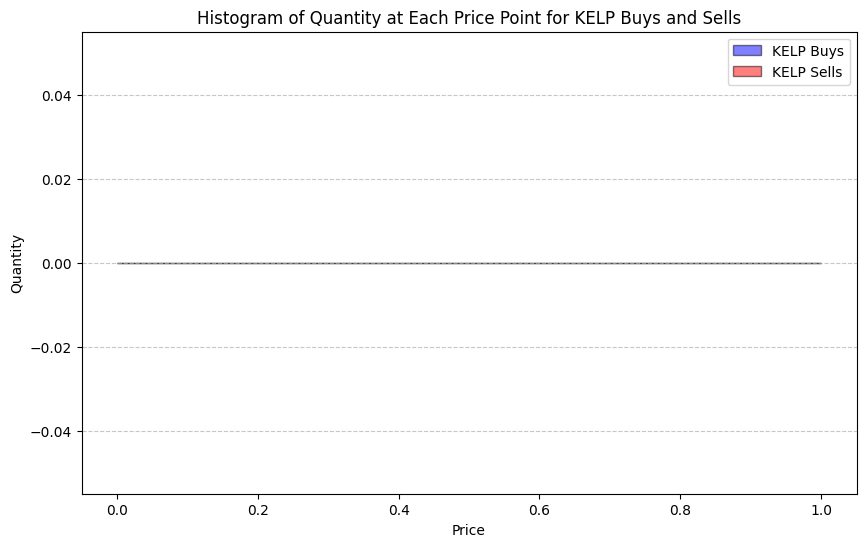

In [352]:
# Extract price and quantity data for rfr_buys and rfr_sells
buy_prices = [trade.price for trade in kelp_buys]
buy_quantities = [trade.quantity for trade in kelp_buys]

sell_prices = [trade.price for trade in kelp_sells]
sell_quantities = [trade.quantity for trade in kelp_sells]

# Create a histogram
plt.figure(figsize=(10, 6))
plt.hist(buy_prices, weights=buy_quantities, bins=20, edgecolor='black', alpha=0.5, label='KELP Buys', color='blue')
plt.hist(sell_prices, weights=sell_quantities, bins=20, edgecolor='black', alpha=0.5, label='KELP Sells', color='red')
plt.title('Histogram of Quantity at Each Price Point for KELP Buys and Sells')
plt.xlabel('Price')
plt.ylabel('Quantity')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [379]:
rfr_pnl = - sum([trade.price * trade.quantity for trade in rfr_buys]) + sum([trade.price * trade.quantity for trade in rfr_sells])
print(f"RFR PnL: {rfr_pnl}")

kelp_pnl = - sum([trade.price * trade.quantity for trade in kelp_buys]) + sum([trade.price * trade.quantity for trade in kelp_sells])
print(f"Kelp PnL: {kelp_pnl}")

squid_ink_pnl = - sum([trade.price * trade.quantity for trade in squid_ink_buys]) + sum([trade.price * trade.quantity for trade in squid_ink_sells])
print(f"Squid Ink PnL: {squid_ink_pnl}")

croissants_pnl = - sum([trade.price * trade.quantity for trade in croissants_buys]) + sum([trade.price * trade.quantity for trade in croissants_sells])
print(f"Croissants PnL: {croissants_pnl}")

jams_pnl = - sum([trade.price * trade.quantity for trade in jams_buys]) + sum([trade.price * trade.quantity for trade in jams_sells])
print(f"Jams PnL: {jams_pnl}")

djembes_pnl = - sum([trade.price * trade.quantity for trade in djembes_buys]) + sum([trade.price * trade.quantity for trade in djembes_sells])
print(f"Djembes PnL: {djembes_pnl}")

pic1_pnl = - sum([trade.price * trade.quantity for trade in pic1_buys]) + sum([trade.price * trade.quantity for trade in pic1_sells])
print(f"Picnic Basket 1 PnL: {pic1_pnl}")

pic2_pnl = - sum([trade.price * trade.quantity for trade in pic2_buys]) + sum([trade.price * trade.quantity for trade in pic2_sells])
print(f"Picnic Basket 2 PnL: {pic2_pnl}")

volcanic_pnl = - sum([trade.price * trade.quantity for trade in volcanic_buys]) + sum([trade.price * trade.quantity for trade in volcanic_sells])
print(f"Volcanic Rock PnL: {volcanic_pnl}")

volcanic_rock_voucher_9500_pnl = - sum([trade.price * trade.quantity for trade in volcanic_rock_voucher_9500_buys]) + sum([trade.price * trade.quantity for trade in volcanic_rock_voucher_9500_sells])
print(f"Volcanic Rock Voucher 9500 PnL: {volcanic_rock_voucher_9500_pnl}")

volcanic_rock_voucher_9750_pnl = - sum([trade.price * trade.quantity for trade in volcanic_rock_voucher_9750_buys]) + sum([trade.price * trade.quantity for trade in volcanic_rock_voucher_9750_sells])
print(f"Volcanic Rock Voucher 9750 PnL: {volcanic_rock_voucher_9750_pnl}")

volcanic_rock_voucher_10000_pnl = - sum([trade.price * trade.quantity for trade in volcanic_rock_voucher_10000_buys]) + sum([trade.price * trade.quantity for trade in volcanic_rock_voucher_10000_sells])
print(f"Volcanic Rock Voucher 10000 PnL: {volcanic_rock_voucher_10000_pnl}")

volcanic_rock_voucher_10250_pnl = - sum([trade.price * trade.quantity for trade in volcanic_rock_voucher_10250_buys]) + sum([trade.price * trade.quantity for trade in volcanic_rock_voucher_10250_sells])
print(f"Volcanic Rock Voucher 10250 PnL: {volcanic_rock_voucher_10250_pnl}")

volcanic_rock_voucher_10500_pnl = - sum([trade.price * trade.quantity for trade in volcanic_rock_voucher_10500_buys]) + sum([trade.price * trade.quantity for trade in volcanic_rock_voucher_10500_sells])
print(f"Volcanic Rock Voucher 10500 PnL: {volcanic_rock_voucher_10500_pnl}")

total_realised_pnl = rfr_pnl + kelp_pnl + squid_ink_pnl + croissants_pnl + jams_pnl + djembes_pnl + pic1_pnl + pic2_pnl\
                        + volcanic_pnl + volcanic_rock_voucher_9500_pnl + volcanic_rock_voucher_9750_pnl + volcanic_rock_voucher_10000_pnl\
                        + volcanic_rock_voucher_10250_pnl + volcanic_rock_voucher_10500_pnl

print(f"Total Realised PnL: {total_realised_pnl}")

total_pnl = total_realised_pnl + total_outstanding_position_value
print(f"Total PnL: {total_pnl}")

RFR PnL: 0
Kelp PnL: 0
Squid Ink PnL: 0
Croissants PnL: 0
Jams PnL: 0
Djembes PnL: 0
Picnic Basket 1 PnL: 0
Picnic Basket 2 PnL: 0
Volcanic Rock PnL: -4032634
Volcanic Rock Voucher 9500 PnL: -133063
Volcanic Rock Voucher 9750 PnL: 45006
Volcanic Rock Voucher 10000 PnL: -34954
Volcanic Rock Voucher 10250 PnL: -6961
Volcanic Rock Voucher 10500 PnL: -1522
Total Realised PnL: -4164128
Total PnL: 20227.5


In [380]:
# basket realised arb pnl
basket_arb_pnl = croissants_pnl + jams_pnl + djembes_pnl + pic1_pnl + pic2_pnl
# unrealised arb 
basket_arb_unrlzd_pnl = (
    outstanding_croissants_position * activities_df[activities_df['product'] == 'CROISSANTS']['mid_price'].iloc[-1] +
    outstanding_djembes_position * activities_df[activities_df['product'] == 'DJEMBES']['mid_price'].iloc[-1] +
    outstanding_jams_position * activities_df[activities_df['product'] == 'JAMS']['mid_price'].iloc[-1] +
    outstanding_pic1_position * activities_df[activities_df['product'] == 'PICNIC_BASKET1']['mid_price'].iloc[-1] +
    outstanding_pic2_position * activities_df[activities_df['product'] == 'PICNIC_BASKET2']['mid_price'].iloc[-1]
)
total_basket_arb_pnl = basket_arb_pnl + basket_arb_unrlzd_pnl
print(f"Basket Arb PnL: {basket_arb_pnl}")
print(f"Basket Arb Unrealised PnL: {basket_arb_unrlzd_pnl}")
print(f"Total Basket Arb PnL: {total_basket_arb_pnl}")






Basket Arb PnL: 0
Basket Arb Unrealised PnL: 0.0
Total Basket Arb PnL: 0.0


In [381]:
# track positions of all trades for each timestep on the activities df by tracking a cumulative sum of trades

symbols = [
    # "RAINFOREST_RESIN",
    # "KELP", "SQUID_INK",
    # "CROISSANTS", "JAMS",
    # "DJEMBES", "PICNIC_BASKET1",
    # "PICNIC_BASKET2",
    "VOLCANINC_ROCK",
    "VOLCANIC_ROCK_VOUCHER_9500", "VOLCANIC_ROCK_VOUCHER_9750",
    "VOLCANIC_ROCK_VOUCHER_10000", "VOLCANIC_ROCK_VOUCHER_10250",
    "VOLCANIC_ROCK_VOUCHER_10500"
]

# Initialize position columns for each symbol




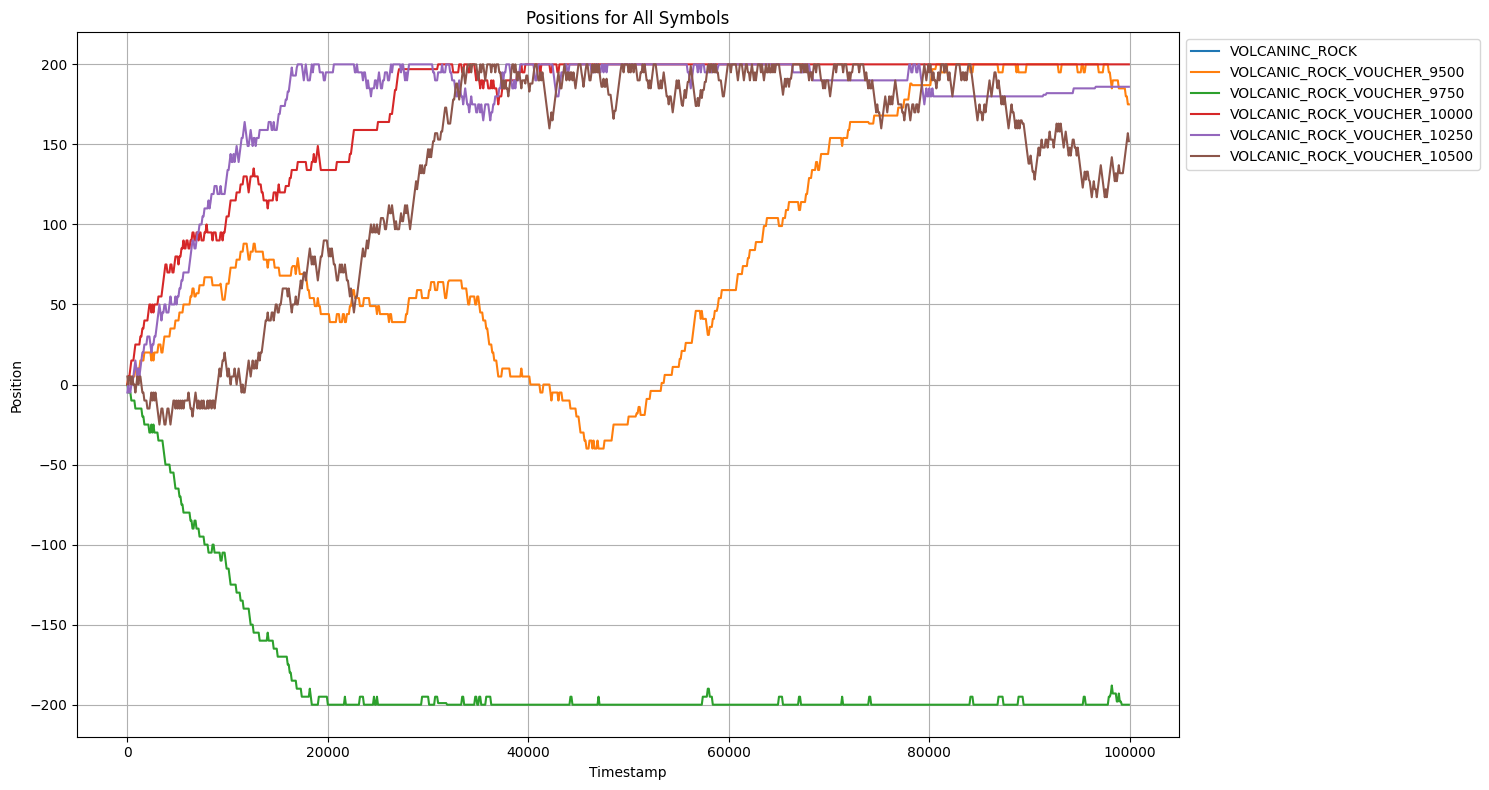

In [382]:
plt.figure(figsize=(15, 8))

for symbol in symbols:
    plt.plot(
        activities_df[activities_df["product"] == symbol]['timestamp'],
        activities_df[activities_df["product"] == symbol]['position'],
        label=symbol
    )

plt.title('Positions for All Symbols')
plt.xlabel('Timestamp')
plt.ylabel('Position')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid()
plt.tight_layout()
plt.show()


In [357]:
import math
from statistics import NormalDist
import numpy as np
from typing import Dict

def volcanic_rock_iv(self, K, timestamp, order_depth):
    N = NormalDist()

    volcanic_rock_order_depth = order_depth["VOLCANIC_ROCK"]
    volcanic_rock_voucher_order_depth = order_depth[f"VOLCANIC_ROCK_VOUCHER_{K}"]

    best_ask = min(volcanic_rock_order_depth['sell_orders'].keys()) if volcanic_rock_order_depth['sell_orders'] else 0
    best_bid = max(volcanic_rock_order_depth['buy_orders'].keys()) if volcanic_rock_order_depth['buy_orders'] else 0
    mid_price = (best_ask + best_bid) / 2

    best_option_ask = min(volcanic_rock_voucher_order_depth['sell_orders'].keys()) if volcanic_rock_voucher_order_depth['sell_orders'] else 0
    best_option_bid = max(volcanic_rock_voucher_order_depth['buy_orders'].keys()) if volcanic_rock_voucher_order_depth['buy_orders'] else 0
    mid_option_price = (best_option_ask + best_option_bid) / 2

    St = mid_price
    Vt = mid_option_price

    TTE = (5 * 1e6 - timestamp) / (1e6 * 365)

    def black_scholes_implied_vol(St, Vt, K, TTE, tol=1e-6, max_iter=50):
        sigma = 0.2
        for _ in range(max_iter):
            d1 = (math.log(St / K) + 0.5 * sigma**2 * TTE) / (sigma * math.sqrt(TTE))
            d2 = d1 - sigma * math.sqrt(TTE)
            delta = N.cdf(d1)
            price = St * delta - K * N.cdf(d2)
            vega = St * N.pdf(d1) * math.sqrt(TTE)
            diff = price - Vt
            if vega < 1e-4:
                break
            if abs(diff) < tol:
                return sigma, delta
            sigma -= diff / vega
        return sigma, delta

    v_t, delta = black_scholes_implied_vol(St, Vt, K, TTE)
    m_t = math.log(K / St) / math.sqrt(TTE)

    return v_t, m_t, delta

def calculate_iv_and_fitted_iv(self, order_depth, timestamp):
    strikes = [K for K in range(9500, 10501, 250)]
    iv_s, m_s, deltas = [], [], []

    for K in strikes:
        v_t, m_t, delta = self.volcanic_rock_iv(K=K, timestamp=timestamp, order_depth=order_depth)
        iv_s.append(v_t)
        m_s.append(m_t)
        deltas.append(delta)

    coeffs = np.polyfit(m_s, iv_s, 2)

    fitted_iv = [coeffs[0] * m**2 + coeffs[1] * m + coeffs[2] for m in m_s]

    return iv_s, fitted_iv, coeffs

# Example usage:
# Assuming `activities_df` contains the activities log and `order_depth` is a dictionary with order book data.
# analysis = VolcanicRockAnalysis(activities_df)
# iv_s, fitted_iv, coeffs = analysis.calculate_iv_and_fitted_iv(order_depth, timestamp=1000000)
# print("Implied Volatilities:", iv_s)
# print("Fitted IV:", fitted_iv)
# print("Coefficients:", coeffs)

In [358]:

volcanic_rock_voucher_df = activities_df[activities_df["product"].str.contains("VOLCANIC_ROCK_VOUCHER")].copy()

In [359]:
# so i want to calculate IV at each timestep according to activities_df

import math
from statistics import NormalDist

def black_scholes_implied_vol(St, Vt, K, TTE, tol=1e-8, max_iter=50):
    if St <= 0 or K <= 0 or TTE <= 0 or Vt <= 0:
        return float('nan')
    
    wrong = 0
    
    N = NormalDist()
    sigma = 0.2
    for _ in range(max_iter):
        iteration = _
        d1 = (math.log(St / K) + 0.5 * sigma**2 * TTE) / (sigma * math.sqrt(TTE))
        d2 = d1 - sigma * math.sqrt(TTE)
        price = St * N.cdf(d1) - K * N.cdf(d2)
        vega = St * N.pdf(d1) * math.sqrt(TTE)
        diff = price - Vt
        if vega < 1e-8:
            return fallback_bisection_iv(St, Vt, K, TTE)
        if abs(diff) < tol:
            # print(f"Iteration {iteration}: Converged with sigma = {sigma}")
            if sigma < 0 or sigma > 2:
                wrong += 1
                print(f"Iteration {iteration}: Sigma out of bounds, returning 0")
                print(f"vega: {vega}, diff: {diff}, St: {St}, K: {K}, TTE: {TTE}, Vt: {Vt}, price: {price}")
                return 0
            return sigma
        sigma -= diff / vega
    # print(f"Iteration {iteration}: Max iterations reached with sigma = {sigma}")
    if sigma < 0 or sigma > 2:
        wrong += 1
        print(f"Iteration {iteration}: Sigma out of bounds, returning 0")
        print(f"vega: {vega}, diff: {diff}, St: {St}, K: {K}, TTE: {TTE}, Vt: {Vt}, price: {price}")
    
    print(f"wrong: {wrong}")
    return sigma


volcanic_rock_df = activities_df[activities_df["product"] == "VOLCANIC_ROCK"].copy()

def fallback_bisection_iv(St, Vt, K, TTE, low=1e-4, high=3.0, tol=1e-4):
    N = NormalDist()
    for _ in range(10):
        mid = (low + high) / 2
        d1 = (math.log(St/K) + 0.5 * mid**2 * TTE) / (mid * math.sqrt(TTE))
        d2 = d1 - mid * math.sqrt(TTE)
        price = St * N.cdf(d1) - K * N.cdf(d2)
        if abs(price - Vt) < tol:
            return mid
        if price > Vt:
            high = mid
        else:
            low = mid
    return mid  # last try

def calculate_tte(timestamp):
    return (5 * 1e6 - timestamp) / (1e6 * 365)

def get_mid_price_at_timestamp(timestamp):
    row = volcanic_rock_df[volcanic_rock_df["timestamp"] == timestamp]
    if not row.empty:
        return row["mid_price"].iloc[0]
    return None

volcanic_rock_voucher_df["implied_volatility"] = volcanic_rock_voucher_df.apply(
    lambda row: black_scholes_implied_vol(
        St=get_mid_price_at_timestamp(row["timestamp"]),
        Vt=row["mid_price"],
        K=float(row["product"].split("_")[-1]),
        TTE=calculate_tte(row["timestamp"])
    ) if get_mid_price_at_timestamp(row["timestamp"]) is not None else None,
    axis=1
)

volcanic_rock_voucher_df["moneyness"] = volcanic_rock_voucher_df.apply(
    lambda row: math.log(float(row["product"].split("_")[-1]) / get_mid_price_at_timestamp(row["timestamp"])) / math.sqrt(calculate_tte(row["timestamp"]))
    if get_mid_price_at_timestamp(row["timestamp"]) is not None else None,
    axis=1
)

# Function to fit a quadratic and calculate fitted volatility
def fit_quadratic_and_calculate_fitted_iv(df):
    fitted_volatilities = []

    # Group by each timestep
    for timestamp, group in df.groupby("timestamp"):
        # Extract moneyness and implied volatility
        moneyness = group["moneyness"].values
        iv = group["implied_volatility"].values

        # Fit a quadratic if there are enough points
        if len(moneyness) >= 3:
            coeffs = np.polyfit(moneyness, iv, 2)
            # Calculate fitted volatility using the quadratic
            fitted_iv = np.polyval(coeffs, moneyness)
            base_iv = coeffs[2]
        else:
            # If not enough points, use NaN
            fitted_iv = [np.nan] * len(moneyness)

        # Append the fitted volatilities
        fitted_volatilities.extend(fitted_iv)

    return fitted_volatilities, base_iv

# Apply the function to calculate fitted volatilities

fitted = fit_quadratic_and_calculate_fitted_iv(volcanic_rock_voucher_df)
volcanic_rock_voucher_df["fitted_volatility"] = fitted[0]
volcanic_rock_voucher_df["base_iv"] = fitted[1]



In [360]:
#plot base iv for 

In [361]:
# find large outliers in both fitted and implied volatilities
def find_large_outliers(df, column, threshold=10):
    mean = df[column].mean()
    outliers = df[(df[column] > mean + threshold) | (df[column] < mean - threshold)]
    return outliers

# Find outliers in both fitted and implied volatilities
implied_volatility_outliers = find_large_outliers(volcanic_rock_voucher_df, "implied_volatility")
fitted_volatility_outliers = find_large_outliers(volcanic_rock_voucher_df, "fitted_volatility")
print("Implied Volatility Outliers:")
print(implied_volatility_outliers)
print("Fitted Volatility Outliers:")
print(fitted_volatility_outliers)

Implied Volatility Outliers:
Empty DataFrame
Columns: [day, timestamp, product, bid_price_1, bid_volume_1, bid_price_2, bid_volume_2, bid_price_3, bid_volume_3, ask_price_1, ask_volume_1, ask_price_2, ask_volume_2, ask_price_3, ask_volume_3, mid_price, profit_and_loss, position, implied_volatility, moneyness, fitted_volatility, base_iv]
Index: []

[0 rows x 22 columns]
Fitted Volatility Outliers:
Empty DataFrame
Columns: [day, timestamp, product, bid_price_1, bid_volume_1, bid_price_2, bid_volume_2, bid_price_3, bid_volume_3, ask_price_1, ask_volume_1, ask_price_2, ask_volume_2, ask_price_3, ask_volume_3, mid_price, profit_and_loss, position, implied_volatility, moneyness, fitted_volatility, base_iv]
Index: []

[0 rows x 22 columns]


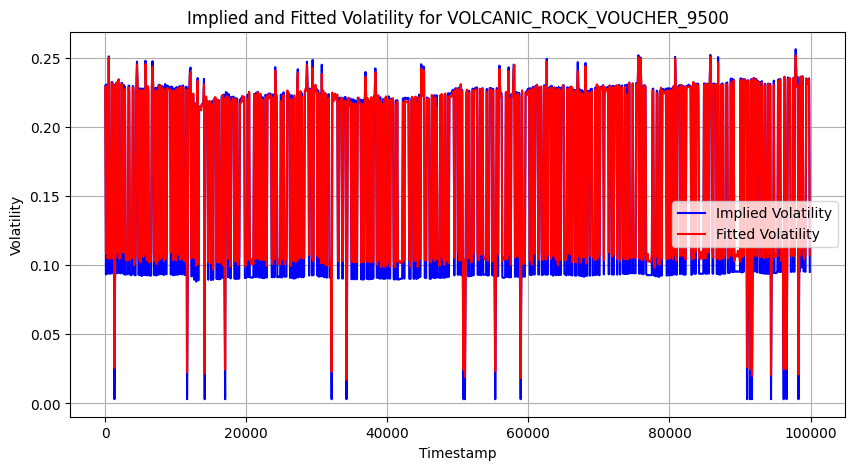

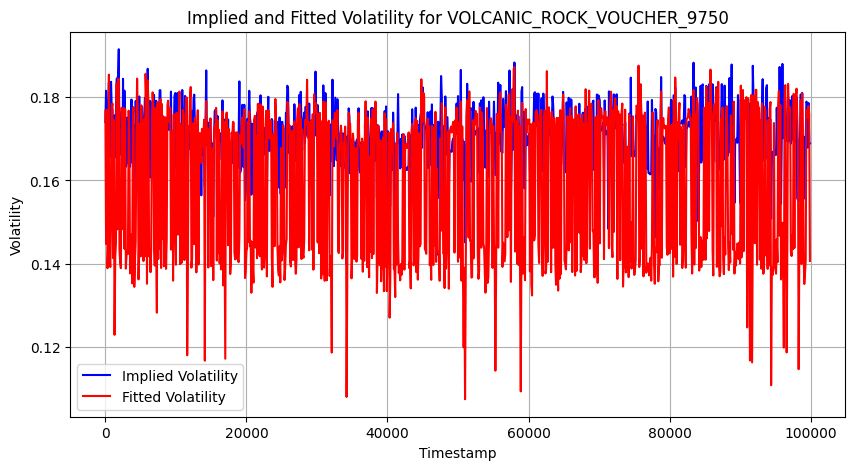

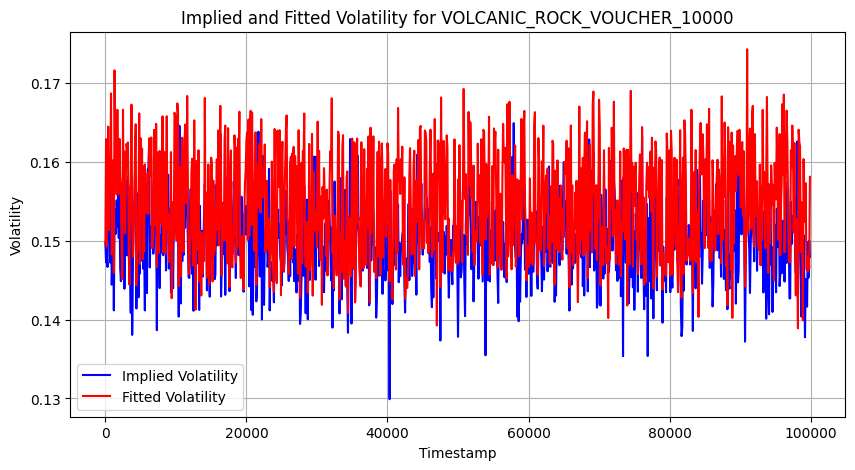

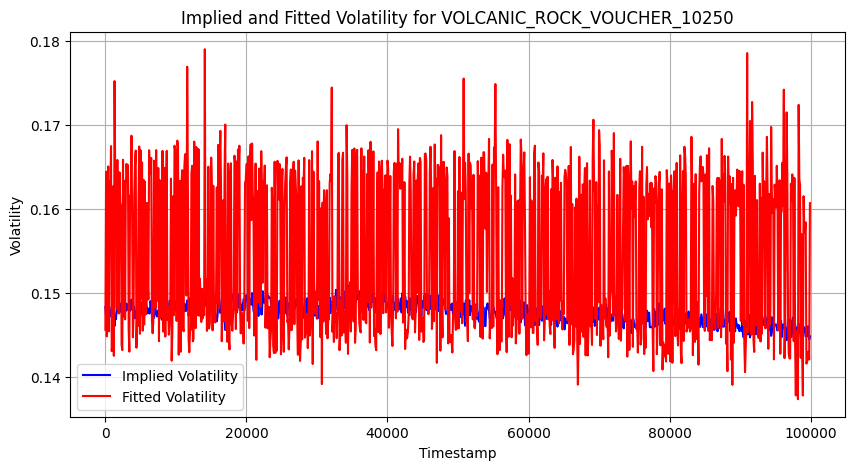

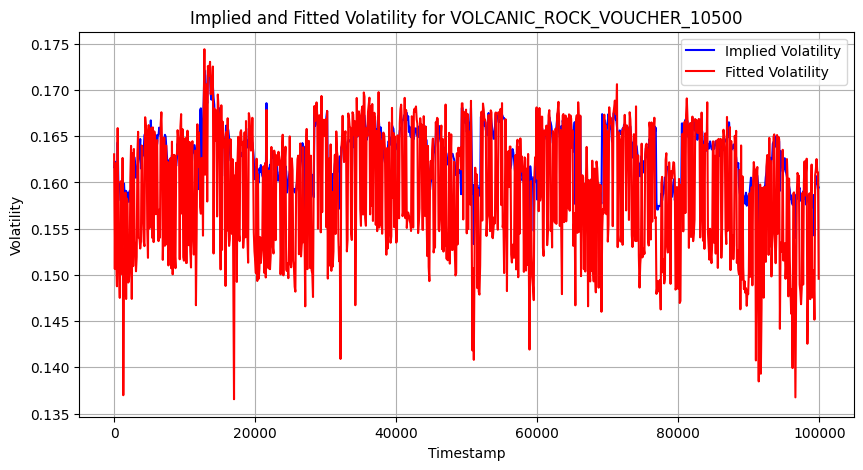

In [362]:
# for each of the vouchers at different strikes, plot the implied volatility and the fitted volatility against time

# Create a dictionary of dataframes for each strike
strike_dfs = {strike: volcanic_rock_voucher_df[volcanic_rock_voucher_df['product'] == f"VOLCANIC_ROCK_VOUCHER_{strike}"] for strike in range(9500, 10501, 250)}

for strike, df in strike_dfs.items():
    plt.figure(figsize=(10, 5))
    plt.plot(df['timestamp'], df['implied_volatility'], label='Implied Volatility', color='blue')
    plt.plot(df['timestamp'], df['fitted_volatility'], label='Fitted Volatility', color='red')
    plt.title(f'Implied and Fitted Volatility for VOLCANIC_ROCK_VOUCHER_{strike}')
    plt.xlabel('Timestamp')
    plt.ylabel('Volatility')
    plt.legend()
    plt.grid()
    plt.show()



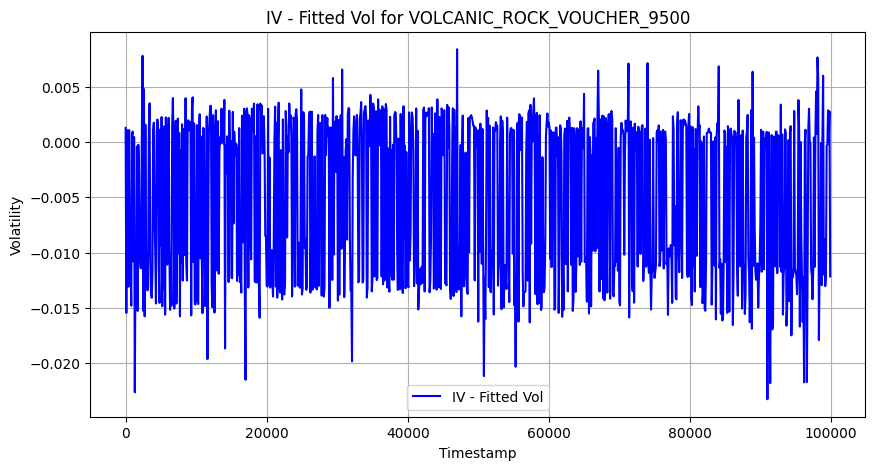

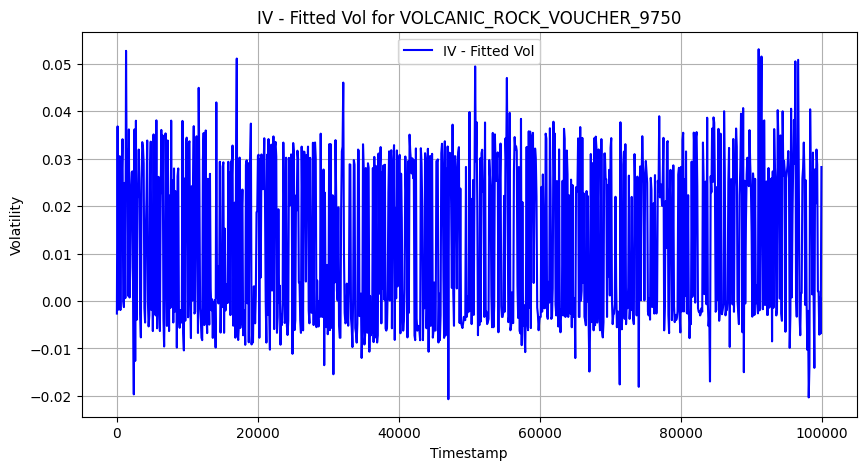

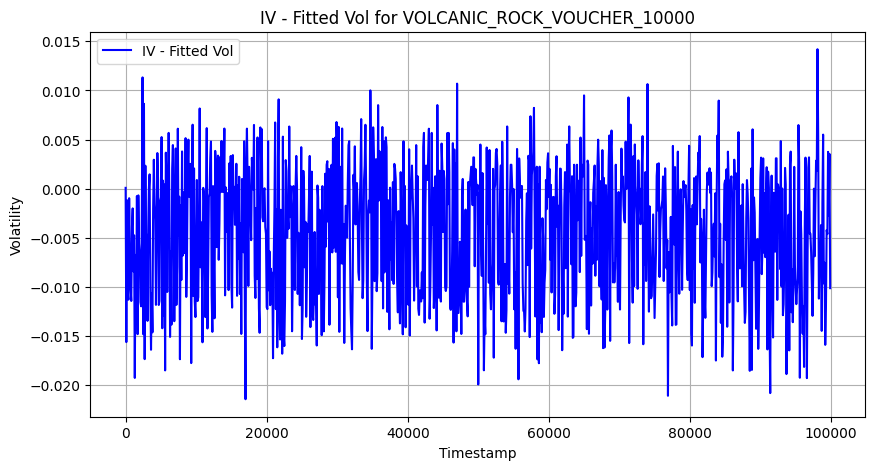

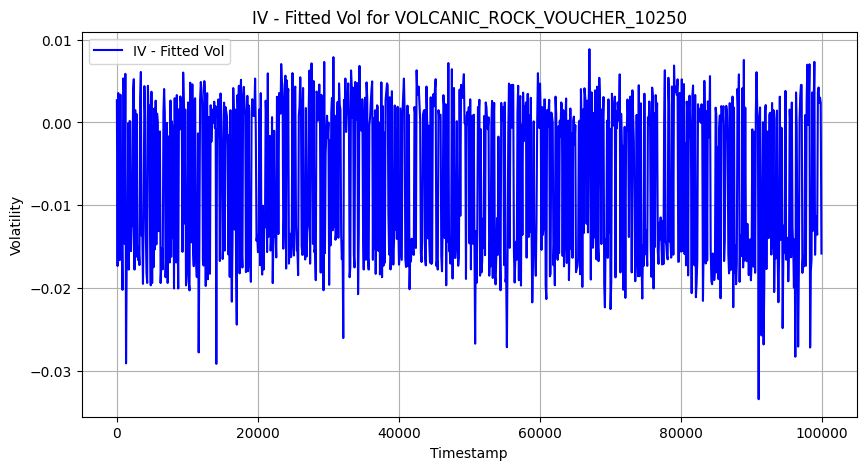

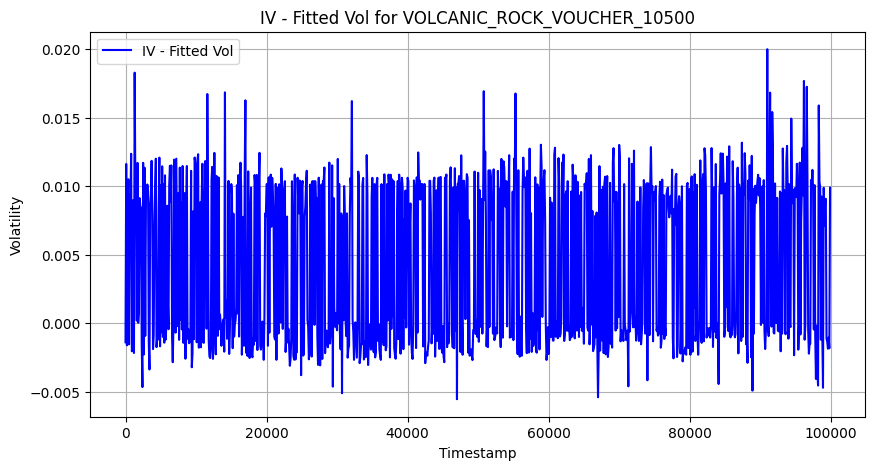

In [363]:
for strike, df in strike_dfs.items():
    plt.figure(figsize=(10, 5))
    plt.plot(df['timestamp'], df['implied_volatility'] - df['fitted_volatility'], label='IV - Fitted Vol', color='blue')
    plt.title(f'IV - Fitted Vol for VOLCANIC_ROCK_VOUCHER_{strike}')
    plt.xlabel('Timestamp')
    plt.ylabel('Volatility')
    plt.legend()
    plt.grid()
    plt.show()

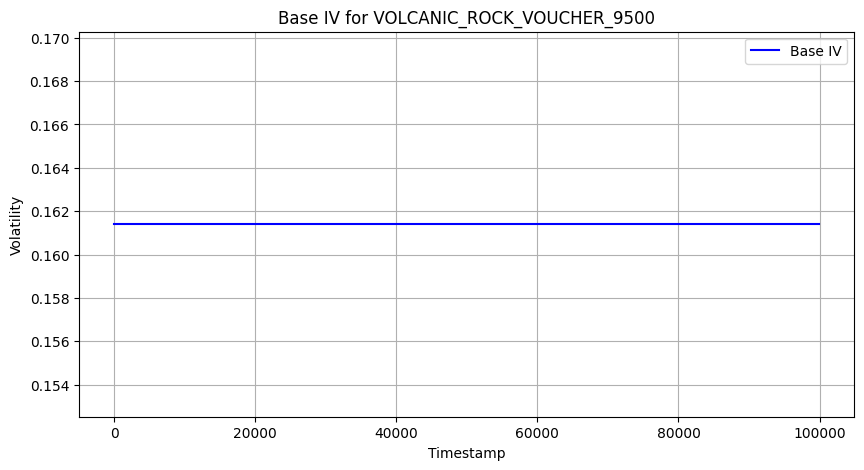

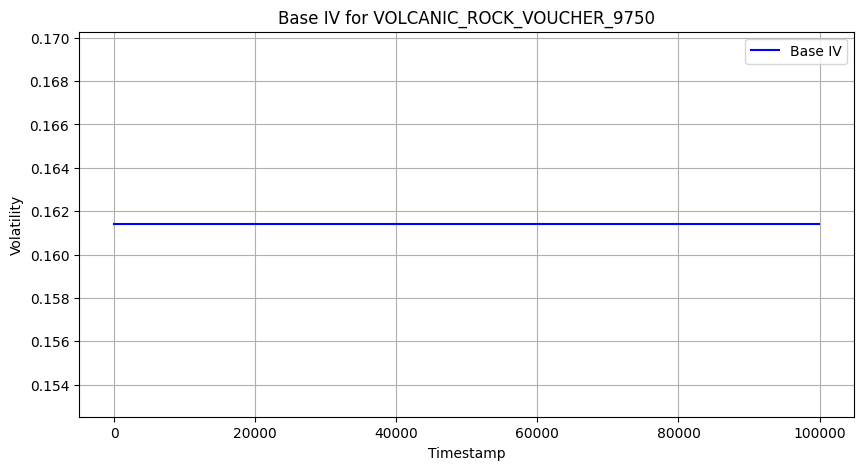

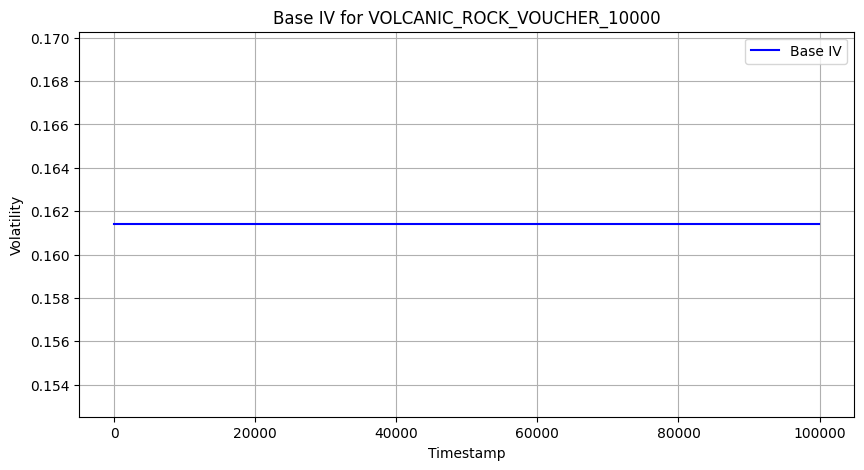

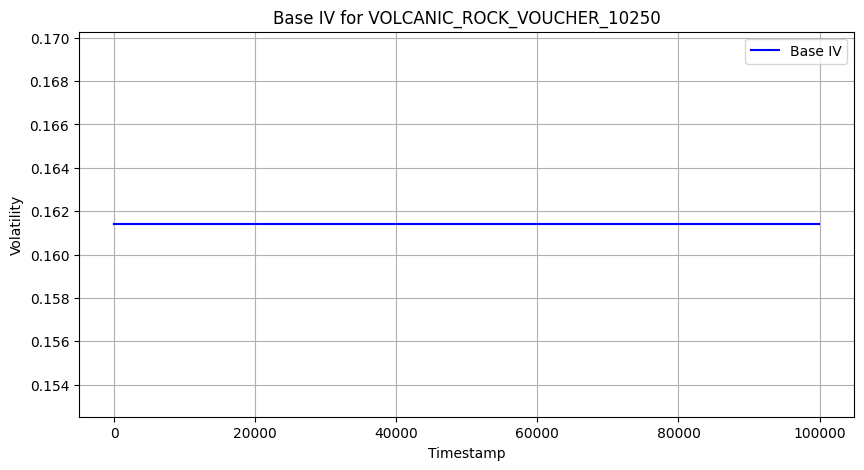

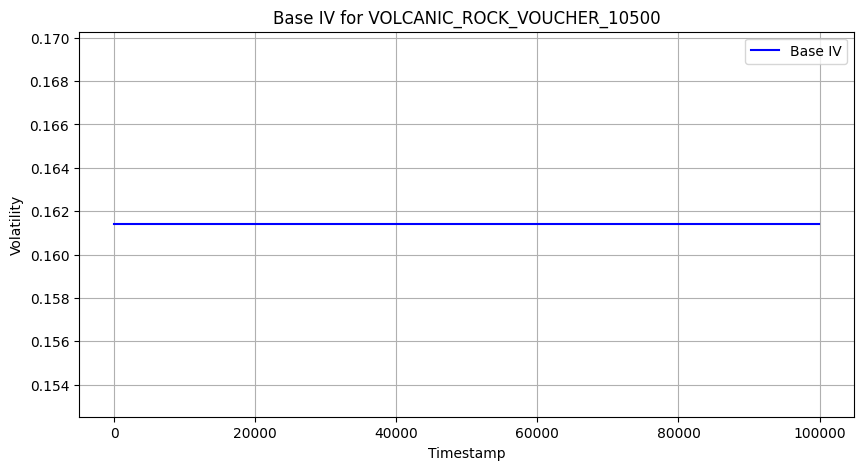

In [364]:
for strike, df in strike_dfs.items():
    plt.figure(figsize=(10, 5))
    plt.plot(df['timestamp'], df['base_iv'], label='Base IV', color='blue')
    plt.title(f'Base IV for VOLCANIC_ROCK_VOUCHER_{strike}')
    plt.xlabel('Timestamp')
    plt.ylabel('Volatility')
    plt.legend()
    plt.grid()
    plt.show()

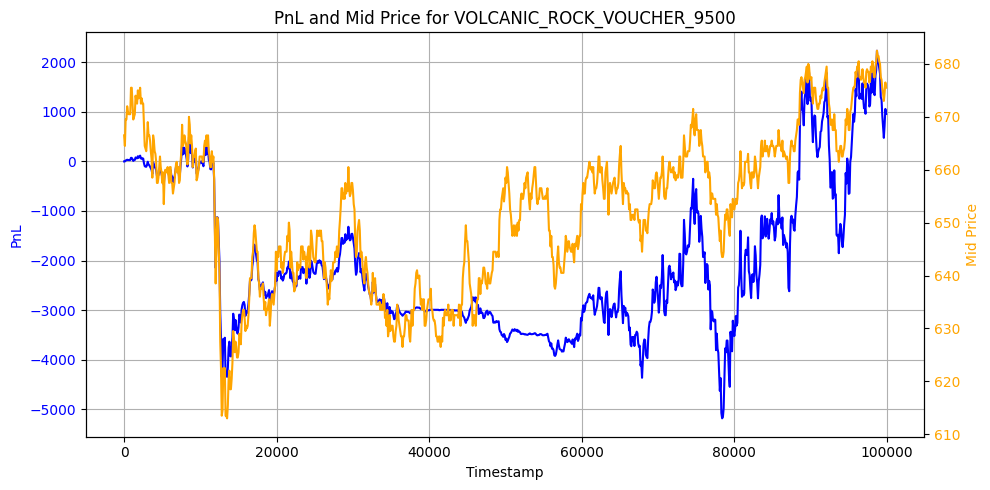

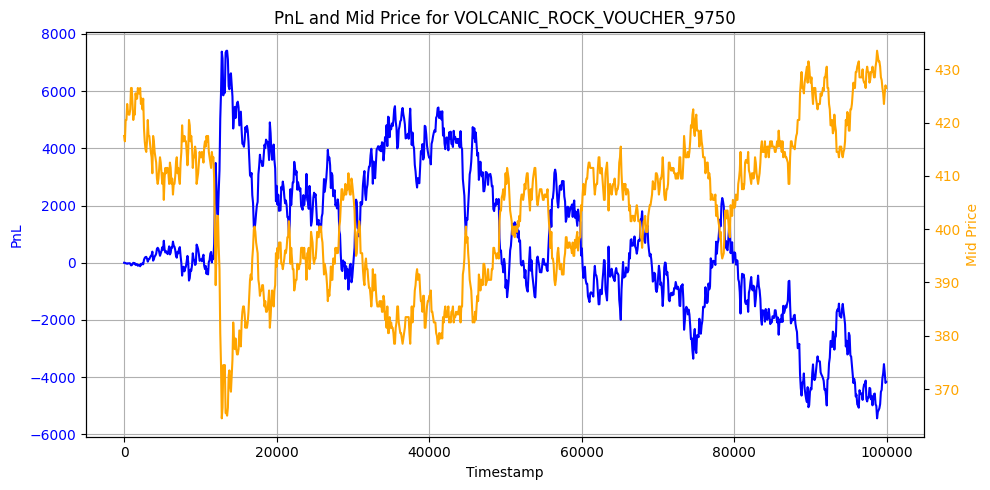

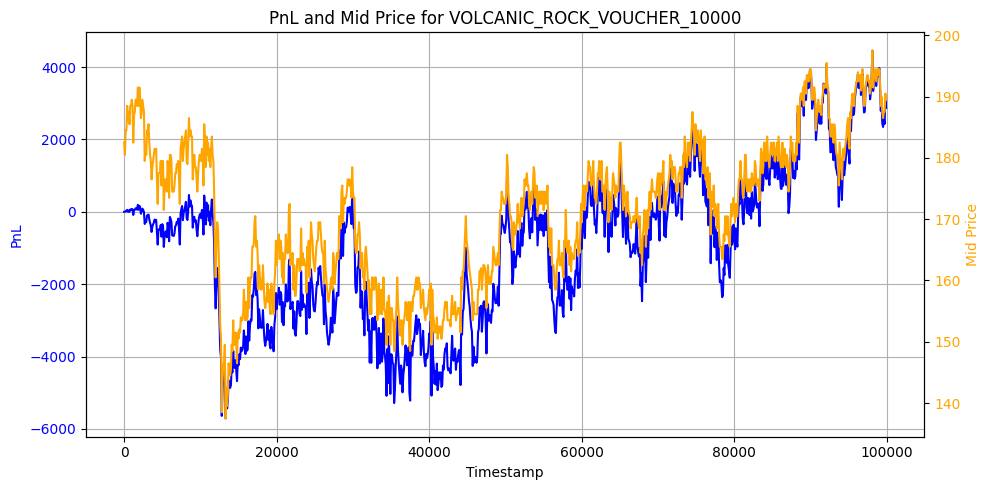

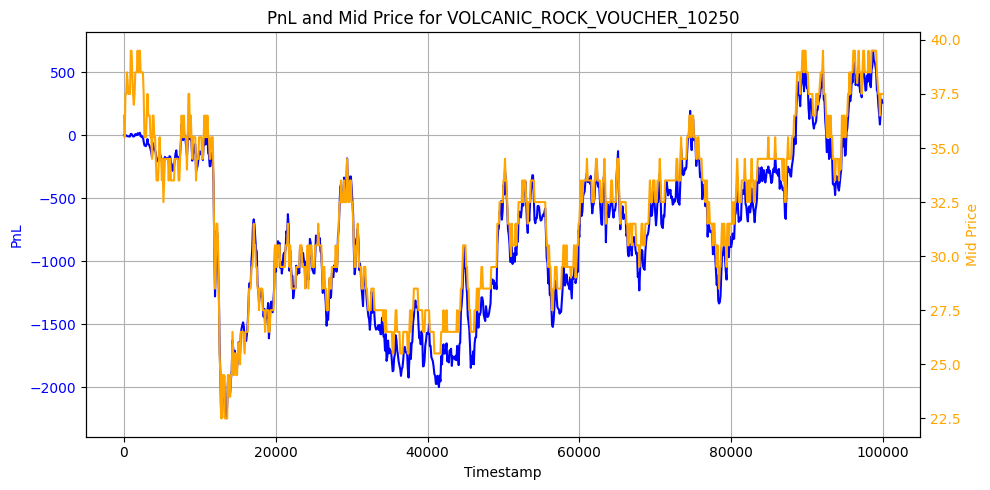

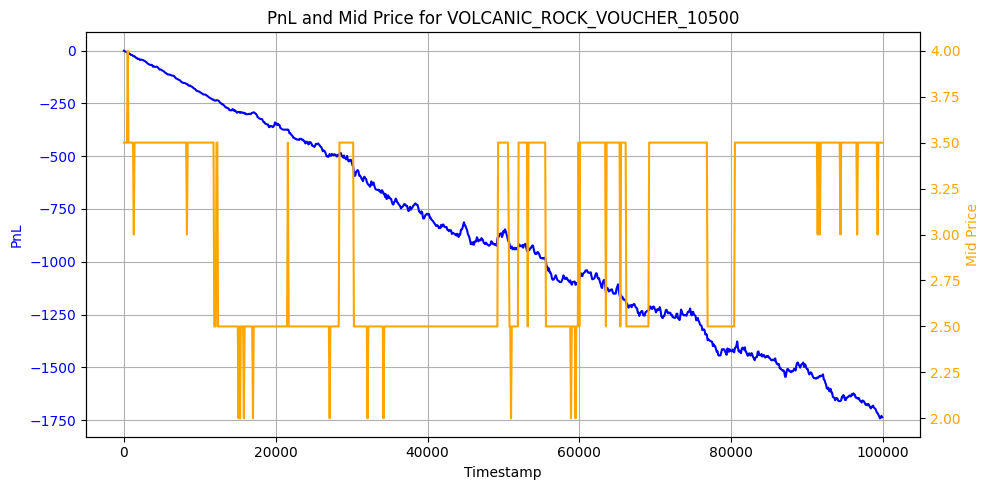

In [368]:
for strike, df in strike_dfs.items():
    fig, ax1 = plt.subplots(figsize=(10, 5))

    # Plot PnL on the primary y-axis
    ax1.plot(df['timestamp'], df['profit_and_loss'], label='PnL', color='blue')
    ax1.set_xlabel('Timestamp')
    ax1.set_ylabel('PnL', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.grid()

    # Create a secondary y-axis for mid price
    ax2 = ax1.twinx()
    ax2.plot(df['timestamp'], df['mid_price'], label='Mid Price', color='orange')
    ax2.set_ylabel('Mid Price', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

    # Add title and legend
    plt.title(f'PnL and Mid Price for VOLCANIC_ROCK_VOUCHER_{strike}')
    fig.tight_layout()
    plt.show()